In [1]:
import os

from IPython.display import display, Markdown, Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline

REPO_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
TASK_PATH = os.path.join(REPO_PATH, "tasks", "10-vectors.md")
DATA_PATH = os.path.join(os.getcwd(), "1551.gov.ua", "raw")

In [3]:
def show_markdown(path):
    with open(path, 'r') as fh:
        content = fh.read()
    display(Markdown(content))

In [4]:
show_markdown(TASK_PATH)

# Векторні представлення

## Завдання 1

Побудуйте покращений класифікатор, який буде предбачати категорію запиту до служби 1551 з використанням тільки векторів слів (не використовувати інші ознаки, такі як самі слова, нграми і т.д) для всіх категорій.

У якості бейзлайну використайте класифікатор kNN, який ви побудували на практичному.

Зробіть як мінімум 2 ітерації покращення, які можуть полягати у:

- підборі найкращого варіанту векторів з наведених тут: https://lang.org.ua/en/models/#anchor4 або інших (fasttext, Tf-IDF, LDA, ...) Ви навіть можете дотренувати вектори на власній тренувальній множині. Можете також спробувати агрегацію декількох векторів.
- будь-яких видах передпроцесингу і попередньої обробки (фільтрація мови, стопслів, службових частин мови, лематизація, нормалізація, ...)
- побудови векторів документу з використанням таких підходів як pargaraph vectors (doc2vec), ElMo, Universal Sentece Encoder...
- використання довільних алгоритмів класифікації та ансамблів цих алгоритмів
- групуванні категорій (на основі кластеризації або якихось евристик) та побудови багаторівневих класифікаторів

Ваша мета: досягнути такого результату по якості, щоб було не соромно дивитись в очі Кличкові. ;)

## Завдання 2

Візуалізуйте ваші класи з використанням t-SNE. Якщо ви будете використовувати агрегацію категорій, то можете візуалізувати тільки категорії вищого рівня і, для прикладу, одну з них. Якщо ви не будете групувати категорії, то використовуйте для візуалізації найбільш частотні (30-50). Спробуйте досягти достатньо розділеної картинки, експериментуючи з параметрами візуалізації (звісно, якщо ваші вхідні дані дозволять вам це).


## Оцінювання

Оцінка:
- 90 балів за класифікатор (рішення, які будуть мати якість більше 0.8 за macro_average або більше 0.9 за micro_average отримають додаткові 10 балів)
- 10 балів за візуалізацію

Крайній термін: 16.05.2020


## Read data

In [5]:
import re
import gzip
import json

import pandas as pd
import numpy as np

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from pathlib import Path
from collections import Counter

In [6]:
import pycld2 as cld2
from langdetect import detect, lang_detect_exception

def lang_detect(x):
    try:
        return detect(x.lower())
    except lang_detect_exception.LangDetectException:
        return ''

def lang_detect_v2(x):
    try:
        x = ''.join(_ for _ in " ".join(x.split()[:100]).lower() if _.isprintable())
        isReliable, textBytesFound, details = cld2.detect(x)
        res = sorted(details, key=lambda x: x[2], reverse=True)[0][1]
        if res == 'un':
            res = detect(x.lower())
        return res
    except:
        return ""

In [7]:
res = []
for file_path in tqdm(Path(DATA_PATH).rglob('*.gz')):
    with gzip.open(file_path, 'rt', encoding='utf8') as zipfile:
        obj = json.load(zipfile)[0]
    res.append(obj)
df = pd.DataFrame(res)

127329it [00:39, 3261.46it/s]


In [8]:
df['manager_name'] = df['CallZManager'].map(lambda x: "" if not re.search(r"\[([\s\w\.]+)\]", x) 
                                                         else re.findall(r"\[([\s\w\.]+)\]", x)[0].strip())
df['entity_name'] = df['CallZManager'].map(lambda x: re.sub(r"\[([\s\w\.]+)\]", "", x))
df['cat_count'] = df['CallZType'].map(df['CallZType'].value_counts().to_dict())
df['word_count'] = df['CallZText'].str.split().map(len)

In [9]:
%%time

lst = process_map(lang_detect, df['CallZText'].values, chunksize=1, max_workers=8)
df['lang'] = lst


CPU times: user 30.6 s, sys: 3.69 s, total: 34.3 s
Wall time: 2min 15s


In [10]:
df['word_count'].describe()

count    127329.000000
mean         63.134384
std          59.138254
min           0.000000
25%          22.000000
50%          45.000000
75%          84.000000
max         418.000000
Name: word_count, dtype: float64

In [11]:
print(f"Records with > 100 label samples: {df.loc[df.cat_count > 100].shape[0] / df.shape[0] * 100:.2f} %")

Records with > 100 label samples: 89.95 %


In [12]:
df['lang'].value_counts()

uk    69342
ru    56948
        540
bg      323
mk      163
pl        5
en        2
et        1
sk        1
sw        1
fr        1
sl        1
ca        1
Name: lang, dtype: int64

In [13]:
# Counter(" ".join(df['entity_name'].values).lower().split()).most_common(10)

In [14]:
data_uk = df.loc[(df.cat_count > 100) & (df.lang.isin(['uk']))]#[['CallZText', 'CallZType']]
data_ru = df.loc[(df.cat_count > 100) & (df.lang.isin(['ru']))]#[['CallZText', 'CallZType']]
data_uk = data_uk.rename(columns=dict(zip(['CallZText', 'CallZType'], ['text', 'label'])))
data_ru = data_ru.rename(columns=dict(zip(['CallZText', 'CallZType'], ['text', 'label'])))
print(data_uk.shape, data_ru.shape)

(61987, 25) (51662, 25)


In [15]:
data_uk.head()

,StatusTitle,CallZCdate,CallZReply,text,CallZManager,label,CallDate,CallCode,FbId,Enabled,...,PY,showStatus,files,feedfiles,reply,manager_name,entity_name,cat_count,word_count,lang
0,Виконано,2015-07-03 00:00:00,,Добрий день! Відповідно до контрольної картки ...,КП ”УЗН” [Сінцов Геннадій Львович ],Утримання парків та лісопарків у місті Києві,2015-06-18 13:20:58,І-2513,149382,1,...,30.636674,,"[{'id': '81573', 'InOut': '0', 'file': '/feedb...","[{'id': '49925', 'file': '/feedback/fdocs/3201...","{'1436176081': {'id': '103381', 'callid': '320...",Сінцов Геннадій Львович,КП ”УЗН”,399,82,uk
2,Виконано,2013-10-21 00:00:00,,В будинку 29 на вулиці Якуба Коласа відсутнє о...,КП РЕО-5 [Бондар Юрій Іванович],Відсутність опалення,2013-10-17 18:20:15,І-4646,28337,1,...,30.383763,,,,[],Бондар Юрій Іванович,КП РЕО-5,6020,55,uk
3,На доопрацюванні виконавцем,2014-01-28 00:00:00,,"Доброго дня, вимушена звертатися за допомогою ...",ПАТ ”Київенерго” - ТРМ [Фоменко Олександр Вале...,Недостатній тиск ГВП,2014-01-13 14:30:50,І-83,40156,1,...,30.414153,,,"[{'id': '12021', 'file': '/feedback/fdocs/2690...","{'1390476591': {'id': '23506', 'callid': '2690...",Фоменко Олександр Валерійович,ПАТ ”Київенерго” - ТРМ,303,97,uk
6,В роботі,2015-05-27 00:00:00,,Відсутне ГВП (в об’яві - на невизначений термін),ПАТ ”Київенерго” - ЖТЕ [Фоменко Олександр Вале...,Відсутність ГВП,2015-05-12 17:43:50,І-1871,136934,1,...,30.432559,,,,[],Фоменко Олександр Валерійович,ПАТ ”Київенерго” - ЖТЕ,13273,8,uk
8,Чекає на перевіку контр.відділом,2014-10-06 00:00:00,,Доброго дня! Вже неможливо терпіти відсутність...,ПАТ ”Київенерго” - ТРМ [Фоменко Олександр Вале...,Відсутність ГВП,2014-09-21 12:10:28,І-2631,74345,1,...,30.63972,,,"[{'id': '21895', 'file': '/feedback/fdocs/2875...",[],Фоменко Олександр Валерійович,ПАТ ”Київенерго” - ТРМ,13273,66,uk


In [16]:
res = df.CallZType.value_counts()

for k, v in res.items():
    if "електро" in k.lower():
        print(v, k)

print('\n****************\n')

for k, v in res.items():
    if "паркув" in k.lower():
        print(v, k)
        
print('\n****************\n')

for k, v in res.items():
    if "опал" in k.lower():
        print(v, k)

print('\n****************\n')

for k, v in res.items():
    if "гвп" in k.lower():
        print(v, k)

print('\n****************\n')

for k, v in res.items():
    if "хвп" in k.lower():
        print(v, k)

565 Відсутнє електропостачання
553 Ремонт та заміна електроприладів
514 Перебої електропостачання
65 Підключення МАФ до комунікацій (електро -, водопостачання, тощо)
62 Встановлення та експлуатація електролічильників
50 Питання нарахування плати за електропостачання (розрахунки за електропостачання)
36 Перерахунок, нарахування плати та боргу  за електропостачання
22 Питання, що стосуються лічильників на електроенергію
19 Відключення електропостачання за борги
14 Питання стосовно нарахування боргу за електропостачання
13 Укладання договорів на постачання електроенергії
8 Перерахунок плати за відсутність електропостачання
4 Відключення за борги електропостачання
1 Про впровадження абонентських книжок АК ”Київенерго”,на оплату за електроенергію

****************

616 Паркування авто у місцях загального користування
359 Паркування авто на прибудинковій території
218 Розміщення паркувальних майданчиків
190 Зберігання транспортних засобів, порушення правил паркування
105 Паркування на зелені

## Preprocessing

In [17]:
import stanfordnlp
import warnings

warnings.filterwarnings("ignore")

In [18]:
MAX_WORDS_NUM = 100

In [19]:
# nlp_uk = stanfordnlp.Pipeline(lang='uk')
# nlp_ru = stanfordnlp.Pipeline(lang='ru')
nlp_uk = stanfordnlp.Pipeline(lang='uk', processors='tokenize,pos,lemma', use_gpu=True)
nlp_ru = stanfordnlp.Pipeline(lang='ru', processors='tokenize,pos,lemma', use_gpu=True)

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_tokenizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_tagger.pt', 'pretrain_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu.pretrain.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/uk_iu_models/uk_iu_lemmatizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
Done loading processors!
---
Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/dima/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_tokenizer.pt', 'lang': 'ru', 'shorthand': 'ru_

In [20]:
def clean_text(x, words_num=100):
    # fix remove bad encoding
    x = x.encode('utf-8', "ignore").decode("utf-8")
    # fix apostrophe
    x = x.replace("”", "’")
    # remove urls
    x = re.sub(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", 
               " ", x)
    # fix repeating punctuation
    punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', 
                   ';', '<', '=', '>', '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '~']
    for punct in punctuation:
        x = re.sub(r"""\{}+""".format(punct), punct, x)
    # remove redundant spaces and limit the number of words to words_num
    x = ''.join(_ for _ in " ".join(filter(None, x.split()[:words_num])).lower() if _.isprintable())
    
    return x


def text2tokens(text, lang='uk', lemma=False, ignore_pos=None, ignore_len=0, ignore_num=False):
    nlp_map = {'uk': nlp_uk, 'ru': nlp_ru}
    nlp = nlp_map.get(lang)
    tokens = []
    
    # remove numbers such as #123, №25а, abc-78 etc.
    if ignore_num:
        text = re.sub(r"\S*\d+\S*", " ", text)
    
    for sentence in nlp(text).sentences:
        for token in sentence.words:
            if ignore_pos:
                if token.upos in ignore_pos:
                    continue
            if ignore_len:
                if len(token.text) <= ignore_len:
                    continue
            if lemma:
                tokens.append(token.lemma)
            else:
#                 tokens.append((token.text, token.upos))
                tokens.append(token.text)
                
    return tokens

In [21]:
sample = data_uk.sample(3)

In [22]:
for item in sample.text.values:
    print(item)
    print("*********")

сьогодні зранку у мене склалась такая ситуація, у ванній кімнаті з лічильника для холодної води тиче вода, я перекрив її. Зателефонуваши до ЖЕК 808 за телефоном 04402909270 мені повідомили, що викликайте приватного сантехніка и вирішуйте свої всі питання з ним, але чекайте я ж платив кошти ЖЕКу 808 за те , що б мені ці лічильники поставили.
*********
За нашою адресою відсутне постачання гарячої води вже 5 діб. 15.10.2015 у дворі будинку розрили яму, ніяких ремонтних робіт ніхто не проводив. 19.10 яму зарили. І все... на всі жалоби та дзвінки відповідають, що в усьому винна міська адміністрація. Також в будинку до 19.10 було відсутне опалення. Температура в квартирі -16 градусів! Нікому нічого не потрібно. Будь-ласка, вирішіть цю проблему!!!!
*********
На сьогодні 22.10.2014 р. в моїй квартирі відсутня гаряча вода ( з 15.10.2014) та відсутне опалення. Терміново прошу повідомити у зв&#039;язку з чим данні обставини.
*********


In [23]:
for item in sample.text.values:
    print(clean_text(item))
    print("*********")

сьогодні зранку у мене склалась такая ситуація, у ванній кімнаті з лічильника для холодної води тиче вода, я перекрив її. зателефонуваши до жек 808 за телефоном 04402909270 мені повідомили, що викликайте приватного сантехніка и вирішуйте свої всі питання з ним, але чекайте я ж платив кошти жеку 808 за те , що б мені ці лічильники поставили.
*********
за нашою адресою відсутне постачання гарячої води вже 5 діб. 15.10.2015 у дворі будинку розрили яму, ніяких ремонтних робіт ніхто не проводив. 19.10 яму зарили. і все. на всі жалоби та дзвінки відповідають, що в усьому винна міська адміністрація. також в будинку до 19.10 було відсутне опалення. температура в квартирі -16 градусів! нікому нічого не потрібно. будь-ласка, вирішіть цю проблему!
*********
на сьогодні 22.10.2014 р. в моїй квартирі відсутня гаряча вода ( з 15.10.2014) та відсутне опалення. терміново прошу повідомити у зв&#039;язку з чим данні обставини.
*********


In [24]:
text2tokens(clean_text(item), ignore_num=True)
# text2tokens(item)

['на',
 'сьогодні',
 'р',
 '.',
 'в',
 'моїй',
 'квартирі',
 'відсутня',
 'гаряча',
 'вода',
 '(',
 'з',
 'та',
 'відсутне',
 'опалення',
 '.',
 'терміново',
 'прошу',
 'повідомити',
 'у',
 'з',
 'чим',
 'данні',
 'обставини',
 '.']

In [25]:
data_uk['text_clean'] = data_uk['text'].map(clean_text)
data_ru['text_clean'] = data_ru['text'].map(clean_text)

## Embeddings

### Universal Sentence Encoder

In [26]:
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub

from scipy import spatial

In [27]:
tf.__version__

'2.0.1'

In [28]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [29]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
use_model = hub.load(module_url)

In [30]:
def cos_sim(vec1, vec2):
    return 1 - spatial.distance.cosine(vec1, vec2)

In [31]:
def use_embed(text, numpy=True):
    res = np.zeros((1, 512))
    if isinstance(text, str):
        text = [text]
    try:
        res = use_model(text)
        if numpy:
            res = res.numpy()
    except Exception as e:
        print(e, text)
    return res

#### sample distance test

##### same topics

In [32]:
lang = 'ru'

if lang == 'ru':
    tmp = data_ru.loc[data_ru.cat_count == data_ru.cat_count.max()].sample(2)
else:
    tmp = data_uk.loc[data_uk.cat_count == data_uk.cat_count.max()].sample(2)
    
cat = tmp['label'].unique()[0]
sample1 = clean_text(tmp['text'].values[0])
sample2 = clean_text(tmp['text'].values[1])

print(cat, sample1, sample2, sep="\n*************\n")

Відсутність ГВП
*************
я проживаю в оболонском районе и уже больше месяца не могу пользоваться горячей водой. дважды я обращалась в контактный центр с просьбой объяснить мне, почему в печерском районе воду не отключили, не отключили воду и на левом берегу.(обращения были зарегистрированы с-13066 и с-13494) я не хотела получить отписку о необходимости экономии газа, а хотела получить ответ на конкретный вопрос. но дважды я под копирку получила ответ из коммунального предприятия моего района о необходимости экономии газа по распоряжению кабмина. значит мы ,живущие в других районах,люди второго сорта? сильные мира сего ,которые лишили нас газа должна процветать, а мы мыться в тазиках.великолепное
*************
здравствуйте! пишу вам с просьбой о помощи в решении проблемы с отключением горячей воды по адресу ул. выборгская 12. в нашем доме уже три недели нет горячего водоснабжения. ни жэк №911 ни ’киевэнерго’ не могут дать внятного ответа кто за что отвечает и когда проблема будет у

In [33]:
print('Embedding shape:', use_embed(sample1).shape)
print('Raw text similarity:', cos_sim(use_embed(sample1), use_embed(sample2)))
print('Clean text similarity:', cos_sim(use_embed(" ".join(text2tokens(sample1))), 
                                        use_embed(" ".join(text2tokens(sample2)))))

Embedding shape: (1, 512)
Raw text similarity: 0.5317729711532593
Clean text similarity: 0.5276922583580017


##### different topics

In [34]:
lang = 'uk'

if lang == 'ru':
    top_2_labels = data_ru.label.value_counts().keys()[:2]
    sample1 = data_ru.loc[data_ru.label == top_2_labels[0]].sample()['text_clean'].values[0]
    sample2 = data_ru.loc[data_ru.label == top_2_labels[1]].sample()['text_clean'].values[0]
    
else:
    top_2_labels = data_uk.label.value_counts().keys()[:2]
    sample1 = data_uk.loc[data_uk.label == top_2_labels[0]].sample()['text_clean'].values[0]
    sample2 = data_uk.loc[data_uk.label == top_2_labels[1]].sample()['text_clean'].values[0]

print(top_2_labels[0], sample1, top_2_labels[1], sample2, sep="\n*************\n")

Відсутність ГВП
*************
я проживаю за вказаною адресою і в будинку з 8.07.2015 по даний час не має гарячої води. вкажіть будь-ласка причину.
*************
Укладання та ремонт асфальтного покриття
*************
доброго дня! звертаю вашу увагу на незадовільний стан асфальтного покриття тротуару біля будинку. заздалегідь вдячна.


In [35]:
print('Embedding shape:', use_embed(sample1).shape)
print('Raw text similarity:', cos_sim(use_embed(sample1), use_embed(sample2)))
print('Clean text similarity:', cos_sim(use_embed(" ".join(text2tokens(sample1))), 
                                        use_embed(" ".join(text2tokens(sample2)))))

Embedding shape: (1, 512)
Raw text similarity: 0.23809470236301422
Clean text similarity: 0.22154812514781952


I'm pleasantly surprised that Russian USE model somehow performs on Ukrainian.
BTW, tokenized text doesn't shows better results comparing to raw clean text. And it makes sense, as we work with document vectors and removing such POSes as NUM or PUNCT breakes document structure

### Word2vec / Glove / LexVec

Ubercorpus embeddings

In [36]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

In [37]:
# glove2word2vec(glove_input_file="ubercorpus.lowercased.tokenized.glove.300d", 
#                word2vec_output_file="ubercorpus.lowercased.tokenized.glove.300d.txt")

In [38]:
%%time

glove_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.glove.300d.txt", binary=False)

CPU times: user 1min 45s, sys: 709 ms, total: 1min 46s
Wall time: 1min 46s


In [39]:
%%time

w2v_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.word2vec.300d", binary=False)

CPU times: user 1min 45s, sys: 749 ms, total: 1min 46s
Wall time: 1min 46s


In [40]:
%%time

lexvec_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.300d", binary=False)

CPU times: user 1min 45s, sys: 706 ms, total: 1min 45s
Wall time: 1min 45s


In [41]:
glove_model.wv.most_similar('москаль', topn=5)

[('геннадій', 0.5712622404098511),
 ('нардеп', 0.5634081959724426),
 ('москаля', 0.5238221883773804),
 ('луценко', 0.5117676258087158),
 ('депутат', 0.49746325612068176)]

In [42]:
w2v_model.wv.most_similar('москаль', topn=5)

[('корбан', 0.703376054763794),
 ('кернес', 0.6943342685699463),
 ('задирко', 0.6910302639007568),
 ('мінаєв', 0.6881823539733887),
 ('іванущенко', 0.676155686378479)]

In [43]:
lexvec_model.wv.most_similar('москаль', topn=5)

[('кернес', 0.6542044878005981),
 ('жебрівський', 0.6423298120498657),
 ('тука', 0.6347901225090027),
 ('зубко', 0.6334406733512878),
 ('корбан', 0.6276117563247681)]

as lowercased model trained on news, wiki and literature, by ``москаль`` it understands ``Генадій Москаль``, but not that dirty ``москаль`` from Mordor. It happens because politician appeared much more frequently in train corpus that the second one. But in my case I can't use cased model, because there are lots of reviews among train data with capsed text and if I will not lowercase them, they will add lots of noise to my data.

In [44]:
def gensim_embed(tokens, mode='avg', model=glove_model, pad_limit=MAX_WORDS_NUM):
    """ average all vectors that are in vocab, ignore OOV """
    res = []
    for token in tokens:
        if token in w2v_model.vocab:
            res.append(model.wv.__getitem__([token]))
    if len(res) > 0:
        res = np.vstack(res)
        
        if mode == 'avg':
            return np.mean(res, axis=0).reshape(1, -1)
        elif mode == 'concat':
            return np.pad(res, ((0, MAX_WORDS_NUM), (0, 0)), mode='constant', constant_values=0)[:MAX_WORDS_NUM, :]
        else:
            raise ValueError(f'Invalid embeddings result mod: {mode}')
    else:
        if mode == 'avg':
            return np.zeros((1, 300))
        else:
            return np.zeros((100, 300))

#### sample distance test

##### Same topics

In [45]:
lang = 'uk'

if lang == 'ru':
    tmp = data_ru.loc[data_ru.cat_count == data_ru.cat_count.max()].sample(2)
else:
    tmp = data_uk.loc[data_uk.cat_count == data_uk.cat_count.max()].sample(2)
    
cat = tmp['label'].unique()[0]
sample1 = clean_text(tmp['text'].values[0])
sample2 = clean_text(tmp['text'].values[1])

print(cat, sample1, sample2, sep="\n*************\n")

Відсутність ГВП
*************
в гарячому крані немає гарячої води. не було місяць-відписалися, що звернення виконано. але воду гарячу включили рівно на два дні, потім через добу появилася тепла- потім взагалі ніяка’холодна-холоднюща’. коли буде гаряча вода з гарячого крану за 40 грн. 1 куб ’такою якою повинна бути’? не має гарячої води - то виключіть мережу? відписки липові ’що виконано’не присилайте, бо буду писати кожний день, доки не набридне.
*************
11/09/2015 за моєю адресою було відключене гвп, яке відновилося 12/09/2015, але температура води в крані гарячої води коливалася протягом доби, не перевищуючи 32°с. починаючи з 18/09/2015 температура гарячої води однакова протягом доби - 28°с, що значно нижче норми (50°с). прошу якнайшвидше виявити і усунуту проблему.


In [46]:
print('Embedding shape:', gensim_embed(text2tokens(sample1)).shape)
print("\nRaw text similarity:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lang=lang), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lang=lang), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lang=lang), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lang=lang), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lang=lang), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lang=lang), model=lexvec_model)))
print("\nLemmatized text similarity:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True), model=lexvec_model)))
print("\nLemmatized text similarity where punct, num and len=1 are ignored:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=lexvec_model)))

Embedding shape: (1, 300)

Raw text similarity:
* w2v: 0.7081223726272583
* glove: 0.8566357493400574
* lexvec: 0.6831431984901428

Lemmatized text similarity:
* w2v: 0.7609636187553406
* glove: 0.8678590655326843
* lexvec: 0.7385969758033752

Lemmatized text similarity where punct, num and len=1 are ignored:
* w2v: 0.7990612983703613
* glove: 0.873092770576477
* lexvec: 0.7790310978889465


##### different topics

In [47]:
lang = 'uk'

if lang == 'ru':
    top_2_labels = data_ru.label.value_counts().keys()[:2]
    sample1 = data_ru.loc[data_ru.label == top_2_labels[0]].sample()['text_clean'].values[0]
    sample2 = data_ru.loc[data_ru.label == top_2_labels[1]].sample()['text_clean'].values[0]
    
else:
    top_2_labels = data_uk.label.value_counts().keys()[:2]
    sample1 = data_uk.loc[data_uk.label == top_2_labels[0]].sample()['text_clean'].values[0]
    sample2 = data_uk.loc[data_uk.label == top_2_labels[1]].sample()['text_clean'].values[0]

print(top_2_labels[0], sample1, top_2_labels[1], sample2, sep="\n*************\n")

Відсутність ГВП
*************
відсутність гарячого водопосточання.
*************
Укладання та ремонт асфальтного покриття
*************
другий рік поспіль звертаюся із проблемою жахливого стану міжквартального проїзду біля дому #4 по вул. празькій. минулого року жек-балансоутримувач даної теріторії відповів: &amp;quot;нема фінансування&amp;quot;. така постановка питання мене, як громадянина, який справно сплачує всі необхідні податки, не влаштовує. вимагаю усунути наведені недоліки.


In [48]:
print('Embedding shape:', gensim_embed(text2tokens(sample1)).shape)
print("\nRaw text similarity:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lang=lang), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lang=lang), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lang=lang), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lang=lang), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lang=lang), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lang=lang), model=lexvec_model)))
print("\nLemmatized text similarity:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True), model=lexvec_model)))
print("\nLemmatized text similarity where punct, num and len=1 are ignored:")
print('* w2v:',    cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=w2v_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=w2v_model)))
print('* glove:',  cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=glove_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=glove_model)))
print('* lexvec:', cos_sim(gensim_embed(text2tokens(sample1, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=lexvec_model), 
                           gensim_embed(text2tokens(sample2, lang=lang, lemma=True, ignore_pos=['PUNCT'], ignore_num=True, ignore_len=1), model=lexvec_model)))

Embedding shape: (1, 300)

Raw text similarity:
* w2v: 0.16053499281406403
* glove: 0.3524405062198639
* lexvec: 0.24383704364299774

Lemmatized text similarity:
* w2v: 0.21585023403167725
* glove: 0.44051629304885864
* lexvec: 0.36627197265625

Lemmatized text similarity where punct, num and len=1 are ignored:
* w2v: 0.22414013743400574
* glove: 0.44372570514678955
* lexvec: 0.3670263886451721


3 comments:
* ukrainian models performs well both on uk and ru
* as I expected, glove works slightly better in most of cases
* no preprocessing neaded. Raw text w/o lemmatization and removing punct, numbers, 1-letter words shows better similarity. Sometimes only lemmatization works slightly better that w/o it. Actually, I'm not sure, it depends on. 

I suppose on long sequences better apply lemmatization and removing some posses, on the short better leave as is.

### BERT

Based on: https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [49]:
BERT_PRETRAINED_DIR = os.path.join(os.getcwd(), 'multi_cased_bert_base_uk')

BERT_VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
BERT_CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
BERT_INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'model.ckpt') # .data-00000-of-00001
PYTORCH_MODEL_SAVE_PATH = os.path.join(BERT_PRETRAINED_DIR, 'pytorch_model.bin')

In [50]:
os.listdir(BERT_PRETRAINED_DIR)

['config.json',
 'vocab.txt',
 'pytorch_model.bin',
 'model.ckpt.meta',
 'model.ckpt.index',
 'model.ckpt.data-00000-of-00001',
 'bert_config.json']

In [51]:
import torch

from pytorch_pretrained_bert import (BertConfig, BertForSequenceClassification, BertTokenizer, 
                                     BertModel, load_tf_weights_in_bert)

In [52]:
bert_config = BertConfig.from_json_file(BERT_CONFIG_FILE)

bert_model = BertForSequenceClassification(bert_config, num_labels=2)

In [53]:
load_tf_weights_in_bert(bert_model, BERT_INIT_CHECKPOINT)

Converting TensorFlow checkpoint from /home/dima/Projects/prj-nlp-2020/students/DimaSakovich/10-vectors/multi_cased_bert_base_uk/model.ckpt
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/beta/adam_m with shape [768]
Loading TF weight bert/embeddings/LayerNorm/beta/adam_v with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma/adam_m with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma/adam_v with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/position_embeddings/adam_m with shape [512, 768]
Loading TF weight bert/embeddings/position_embeddings/adam_v with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/token_type_embeddings/adam_m with shape [2, 768]
Loading TF weight bert/embedding

Loading TF weight bert/encoder/layer_1/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_1/output/LayerNorm/beta/adam_m with shape [768]
Loading TF weight bert/encoder/layer_1/output/LayerNorm/beta/adam_v with shape [768]
Loading TF weight bert/encoder/layer_1/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_1/output/LayerNorm/gamma/adam_m with shape [768]
Loading TF weight bert/encoder/layer_1/output/LayerNorm/gamma/adam_v with shape [768]
Loading TF weight bert/encoder/layer_1/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_1/output/dense/bias/adam_m with shape [768]
Loading TF weight bert/encoder/layer_1/output/dense/bias/adam_v with shape [768]
Loading TF weight bert/encoder/layer_1/output/dense/kernel with shape [3072, 768]
Loading TF weight bert/encoder/layer_1/output/dense/kernel/adam_m with shape [3072, 768]
Loading TF weight bert/encoder/layer_1/output/dense/kernel/adam_v with shape [3072, 768]
Loadi

Loading TF weight bert/encoder/layer_11/output/dense/kernel/adam_m with shape [3072, 768]
Loading TF weight bert/encoder/layer_11/output/dense/kernel/adam_v with shape [3072, 768]
Loading TF weight bert/encoder/layer_2/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/LayerNorm/beta/adam_m with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/LayerNorm/beta/adam_v with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/LayerNorm/gamma/adam_m with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/LayerNorm/gamma/adam_v with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/dense/bias/adam_m with shape [768]
Loading TF weight bert/encoder/layer_2/attention/output/dense/bias/adam_v with shape [

Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/beta/adam_m with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/beta/adam_v with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/gamma/adam_m with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/gamma/adam_v with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/bias/adam_m with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/bias/adam_v with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/kernel/adam_m with sha

Loading TF weight bert/encoder/layer_6/attention/self/key/bias/adam_m with shape [768]
Loading TF weight bert/encoder/layer_6/attention/self/key/bias/adam_v with shape [768]
Loading TF weight bert/encoder/layer_6/attention/self/key/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_6/attention/self/key/kernel/adam_m with shape [768, 768]
Loading TF weight bert/encoder/layer_6/attention/self/key/kernel/adam_v with shape [768, 768]
Loading TF weight bert/encoder/layer_6/attention/self/query/bias with shape [768]
Loading TF weight bert/encoder/layer_6/attention/self/query/bias/adam_m with shape [768]
Loading TF weight bert/encoder/layer_6/attention/self/query/bias/adam_v with shape [768]
Loading TF weight bert/encoder/layer_6/attention/self/query/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_6/attention/self/query/kernel/adam_m with shape [768, 768]
Loading TF weight bert/encoder/layer_6/attention/self/query/kernel/adam_v with shape [768, 768]
Loading TF

Loading TF weight bert/encoder/layer_8/intermediate/dense/kernel with shape [768, 3072]
Loading TF weight bert/encoder/layer_8/intermediate/dense/kernel/adam_m with shape [768, 3072]
Loading TF weight bert/encoder/layer_8/intermediate/dense/kernel/adam_v with shape [768, 3072]
Loading TF weight bert/encoder/layer_8/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_8/output/LayerNorm/beta/adam_m with shape [768]
Loading TF weight bert/encoder/layer_8/output/LayerNorm/beta/adam_v with shape [768]
Loading TF weight bert/encoder/layer_8/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_8/output/LayerNorm/gamma/adam_m with shape [768]
Loading TF weight bert/encoder/layer_8/output/LayerNorm/gamma/adam_v with shape [768]
Loading TF weight bert/encoder/layer_8/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_8/output/dense/bias/adam_m with shape [768]
Loading TF weight bert/encoder/layer_8/output/dense/bias/adam_v with

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
  

In [54]:
torch.save(bert_model.state_dict(), PYTORCH_MODEL_SAVE_PATH)

#### tokenize

In [55]:
tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_DIR)

In [56]:
text = "вже майже добу відсутня гаряча вода"
marked_text = "[CLS] " + text + " [SEP]"

tokenized_text = tokenizer.tokenize(marked_text)

print(tokenized_text)

['[CLS]', 'вже', 'ма', '##иже', 'до', '##бу', 'від', '##су', '##тня', 'га', '##ря', '##ча', 'вода', '[SEP]']


In [57]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
вже          23,692
ма           97,744
##иже        94,152
до           10,344
##бу         19,590
від          11,141
##су         16,417
##тня        80,897
га           16,616
##ря         39,025
##ча         13,035
вода         30,953
[SEP]           102


#### segment ids

In [58]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


I don't know why, but TF tokenizer works not correctly and doesn't recognize [CLS] and [SEP] tokens

#### load model

In [59]:
bert_model = BertModel.from_pretrained(BERT_PRETRAINED_DIR)

bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Li

In [60]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [61]:
with torch.no_grad():
    encoded_layers, _ = bert_model(tokens_tensor, segments_tensors)

#### study the output

The layer number (12 layers)  
The batch number (1 sentence)  
The word / token number (14 tokens in our sentence)  
The hidden unit / feature number (768 features)

In [62]:
layer_i, batch_i, token_i = 0, 0, 0

print ("Number of layers:", len(encoded_layers))
print ("Number of batches:", len(encoded_layers[layer_i]))
print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 14
Number of hidden units: 768


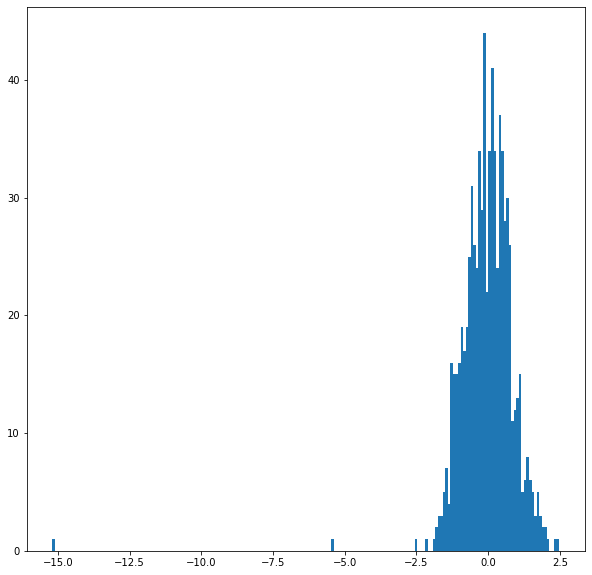

In [63]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Current dimensions:

``[# layers, # batches, # tokens, # features]``

Desired dimensions:

``[# tokens, # layers, # features]``

We remove dimension 1, the "batches", as we don't need it.

In [64]:
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()

torch.Size([12, 1, 14, 768])

In [65]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([12, 14, 768])

In [66]:
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([14, 12, 768])

#### bert word embeddings

Good blog with recomendations [Jay Allamar’s blog](http://jalammar.github.io/illustrated-bert/). Image also from there 

![text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

In [67]:
def bert_word_emb(text):
    marked_text = "[CLS] " + text + " [SEP]"
    
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    with torch.no_grad():
        encoded_layers, _ = bert_model(tokens_tensor, segments_tensors)
        
    token_embeddings = torch.stack(encoded_layers, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    
    return token_embeddings

##### concatenate the last four layers

In [68]:
def bert_emb_concat(emb):
    token_vecs_concat = []

    for token in token_embeddings:
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        token_vecs_concat.append(cat_vec)
        
    return torch.stack(token_vecs_concat, dim=0)

In [69]:
token_vecs_concat = bert_emb_concat(bert_word_emb(text))

print (f'shape: {token_vecs_concat.shape}')

shape: torch.Size([14, 3072])


##### sum last four layers

In [70]:
def bert_emb_sum(emb):
    token_vecs_sum = []

    for token in token_embeddings:
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
        
    return torch.stack(token_vecs_sum, dim=0)

In [71]:
token_vecs_sum = bert_emb_sum(bert_word_emb(text))

print (f'shape: {token_vecs_sum.shape}')

shape: torch.Size([14, 768])


#### bert sentence embeddings

Simple approach is to average the second to last hidden layer of each token producing a single 768 length vector.

In [72]:
def bert_sent_emb(text):
    token_embeddings = bert_word_emb(text)
    token_vecs = token_embeddings[:, 11]
    sentence_embedding = torch.mean(token_vecs, dim=0).reshape(1, -1)

    return sentence_embedding

In [73]:
sentence_embedding = bert_sent_emb(text)
print(sentence_embedding.shape)

torch.Size([1, 768])


#### sample distance test

##### same topic similarity

In [74]:
lang = 'uk'

if lang == 'ru':
    tmp = data_ru.loc[data_ru.cat_count == data_ru.cat_count.max()].sample(2)
else:
    tmp = data_uk.loc[data_uk.cat_count == data_uk.cat_count.max()].sample(2)
    
cat = tmp['label'].unique()[0]
sample1 = clean_text(tmp['text'].values[0])
sample2 = clean_text(tmp['text'].values[1])

print(cat, sample1, sample2, sep="\n*************\n")

Відсутність ГВП
*************
хочу дізнатися причину відсутності гвп і термін його відсутності
*************
відсутня гаряча вода, більше місяця


In [75]:
print('Embedding shape:', bert_sent_emb(sample1).shape)
print('Raw text similarity:', cos_sim(bert_sent_emb(sample1), bert_sent_emb(sample2)))
print('Clean text similarity:', cos_sim(bert_sent_emb(" ".join(text2tokens(sample1, lemma=True))), 
                                        bert_sent_emb(" ".join(text2tokens(sample2, lemma=True)))))

Embedding shape: torch.Size([1, 768])
Raw text similarity: 0.9865012168884277
Clean text similarity: 0.9914160370826721


##### different topic similarity

In [76]:
lang = 'uk'

if lang == 'ru':
    top_2_labels = data_ru.label.value_counts().keys()[:2]
    sample1 = data_ru.loc[data_ru.label == top_2_labels[0]].sample()['text_clean'].values[0]
    sample2 = data_ru.loc[data_ru.label == top_2_labels[1]].sample()['text_clean'].values[0]
    
else:
    top_2_labels = data_uk.label.value_counts().keys()[:2]
    sample1 = data_uk.loc[data_uk.label == top_2_labels[0]].sample()['text_clean'].values[0]
    sample2 = data_uk.loc[data_uk.label == top_2_labels[1]].sample()['text_clean'].values[0]

print(top_2_labels[0], sample1, top_2_labels[1], sample2, sep="\n*************\n")

Відсутність ГВП
*************
коли нарешті буде нормальне постачання теплої води? тарифи на воду підняли, а з теплого крану йде холодна вода.
*************
Укладання та ремонт асфальтного покриття
*************
повторне звернення стосовно скарги т-1241. за три місяці так і не було отримано ні відповіді від начальника кп «ужг», ні вирішення проблеми. прошу ще раз поставити питання що до асфальтування ям на вказаному відрізку у зверненні т-1241, або вказати причину відмови чи неможливості вирішення цього питання. дякую.


In [77]:
print('Embedding shape:', bert_sent_emb(sample1).shape)
print('Raw text similarity:', cos_sim(bert_sent_emb(sample1), bert_sent_emb(sample2)))
print('Clean text similarity:', cos_sim(bert_sent_emb(" ".join(text2tokens(sample1, lemma=True))), 
                                        bert_sent_emb(" ".join(text2tokens(sample2, lemma=True)))))

Embedding shape: torch.Size([1, 768])
Raw text similarity: 0.9841408729553223
Clean text similarity: 0.9958609342575073


I assume, Ukrainian BERT trained on tragically small amount of data, which leads to such result as you see above.
Averaging is total fail. Maybe should be tried word embeddings instead of sentence for training purposes

### Finalize and train/test split

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
data = pd.concat([data_ru, data_uk])[['text_clean', 'label']]
target = data['label']

In [80]:
RANDOM_SEED = 0
num_classes = target.unique().shape[0]

##### prepare USE embeddings

In [81]:
res = []

for i in tqdm(range(int(data.shape[0] / 100) + 1)):
    res.append(use_embed(data['text_clean'].values[i*100:(i+1)*100]))

use_vec = np.vstack(res)

100%|██████████| 1137/1137 [00:53<00:00, 21.13it/s]


In [82]:
use_vec.shape

(113649, 512)

##### prepare BERT embeddings

In [83]:
try:
    bert_vec = torch.load('bert_emb.pt')
except FileNotFoundError:
    res = []
    for item in tqdm(data['text_clean'].values):
        res.append(bert_sent_emb(item))
    bert_vec = torch.squeeze(torch.stack(res, dim=0), dim=1)
    torch.save(bert_vec, 'bert_emb.pt')

In [84]:
bert_vec = bert_vec.numpy()

In [85]:
bert_vec.shape

(113669, 768)

##### prepare GloVe embeddings

In [86]:
mode = 'concat'

In [100]:
try:
    glove_uk = np.load(f'glove_uk_{mode}.npy')
except FileNotFoundError:
    res_uk = []
    for item in tqdm(data_uk['text_clean']):
        res_uk.append(gensim_embed(text2tokens(item, lang='uk'), mode=mode, model=glove_model))
    glove_uk = np.stack(res_uk, axis=0)
    np.save(f'glove_uk_{mode}.npy', np.vstack(res_uk))

In [ ]:
try:
    glove_ru = np.load(f'glove_ru_{mode}.npy')
except FileNotFoundError:
    res_ru = []
    for item in tqdm(data_ru['text_clean']):
        res_ru.append(gensim_embed(text2tokens(item, lang='ru'), mode=mode, model=glove_model))
    glove_ru = np.stack(res_ru, axis=0)
    np.save(f'glove_ru_{mode}.npy', np.vstack(res_ru))

In [ ]:
glove_vec = np.vstack([glove_ru, glove_uk])

In [ ]:
glove_vec.shape

In [ ]:
idx = 42

tmp = glove_vec[idx].reshape(1, -1) == gensim_embed(
    text2tokens(data_ru['text_clean'].values[idx], lang='ru'), mode=mode, model=glove_model
)
print(f"Loaded GloVe vectors are {'NOT '*(np.any(tmp) == False)}correct")

In [ ]:
labels_mapping = dict(enumerate(target.unique(), 1))

In [101]:
# Choose embeddings by assigning x_vec variable
x_vec = use_vec

labels = pd.get_dummies(target).columns

X_train, X_test, y_train, y_test = train_test_split(x_vec, target, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=target)

X_train_reshaped, X_test_reshaped = X_train.reshape(-1, x_vec.shape[1], 1), X_test.reshape(-1, x_vec.shape[1], 1)
y_train_ohe, y_test_ohe = pd.get_dummies(y_train)[labels].values, pd.get_dummies(y_test)[labels].values

In [102]:
print(X_train_reshaped.shape, X_test_reshaped.shape)
print(y_train_ohe.shape, y_test_ohe.shape)

(90919, 512, 1) (22730, 512, 1)
(90919, 186) (22730, 186)


In [103]:
y_train_ohe

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Modeling

### Baseline

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

In [105]:
%%time

knn_clf = KNeighborsClassifier(n_neighbors=5, metric='cosine')

knn_clf.fit(X_train, y_train)

CPU times: user 281 ms, sys: 0 ns, total: 281 ms
Wall time: 280 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [106]:
pred = knn_clf.predict(X_test)

print(classification_report(pred, y_test))

                                                                                  precision    recall  f1-score   support

                                                                     Інші Подяки       0.20      0.20      0.20        99
                                              Інші технічні недоліки стану ліфту       0.56      0.31      0.40       523
                Аварійний, травмонебезпечний стан утримання об’єктів благоустрою       0.17      0.13      0.15       117
                                          Бажаючі отримати ”Картки киянина (КК)”       0.77      0.42      0.55        40
                              Будівництво /дооблаштування спортивних майданчиків       0.56      0.35      0.43        52
                                                                 Будівництво АЗС       0.45      0.36      0.40        36
                                                        Будівництво в нічний час       0.55      0.31      0.39        39
                       

### Simple NNs

In [107]:
def create_model(name, max_sequence_len,
                 activation_cnn = 'relu',
                 activation_final = 'softmax'):
    
    model_input = tf.keras.layers.Input(shape=(max_sequence_len, 1))
    
    cnn1 = tf.keras.layers.Convolution1D(128, 3, padding='same', strides=1, activation=activation_cnn)(model_input)
    cnn1 = tf.keras.layers.MaxPool1D(pool_size=4)(cnn1)
    
    cnn2 = tf.keras.layers.Convolution1D(64, 5, padding='same', strides=1, activation=activation_cnn)(model_input)
    cnn2 = tf.keras.layers.MaxPool1D(pool_size=4)(cnn2)
    
    cnn3 = tf.keras.layers.Convolution1D(64, 7, padding='same', strides=1, activation=activation_cnn)(model_input)
    cnn3 = tf.keras.layers.MaxPool1D(pool_size=4)(cnn3)
    
    cnn = tf.keras.layers.concatenate([cnn1, cnn2, cnn3], axis=-1)
#     pool = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(cnn)
    drop1 = tf.keras.layers.Dropout(rate=0.3)(cnn)
    
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(drop1)

    flat = tf.keras.layers.Flatten()(lstm)
#     drop2 = tf.keras.layers.Dropout(rate=0.2)(flat)
    
    model_output = tf.keras.layers.Dense(num_classes, activation=activation_final)(flat)
    
    model = tf.keras.models.Model(inputs=model_input, outputs=model_output, name=name)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [108]:
model = create_model(name='cnn_bilstm_model', max_sequence_len=X_train.shape[1])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2, verbose=True), 
    tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='cnn_bilstm_model.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "cnn_bilstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 512, 128)     512         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 64)      512         input_1[0][0]                    
___________________________________________________________________________________

In [109]:
history = model.fit(X_train_reshaped, y_train_ohe,
                    class_weight='balanced',
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=(X_test_reshaped, y_test_ohe),
#                     validation_split=0.1,
                    verbose=1)

Train on 90919 samples, validate on 22730 samples
Epoch 1/100
90848/90919 [============================>.] - ETA: 0s - loss: 2.4320 - categorical_accuracy: 0.4223
Epoch 00001: val_loss improved from inf to 1.98919, saving model to cnn_bilstm_model.h5
90919/90919 [==============================] - 46s 510us/sample - loss: 2.4317 - categorical_accuracy: 0.4224 - val_loss: 1.9892 - val_categorical_accuracy: 0.5008
Epoch 2/100
90816/90919 [============================>.] - ETA: 0s - loss: 1.7641 - categorical_accuracy: 0.5380
Epoch 00002: val_loss improved from 1.98919 to 1.75903, saving model to cnn_bilstm_model.h5
90919/90919 [==============================] - 42s 465us/sample - loss: 1.7642 - categorical_accuracy: 0.5379 - val_loss: 1.7590 - val_categorical_accuracy: 0.5457
Epoch 3/100
90912/90919 [============================>.] - ETA: 0s - loss: 1.4589 - categorical_accuracy: 0.6028
Epoch 00003: val_loss improved from 1.75903 to 1.68848, saving model to cnn_bilstm_model.h5
90919/90919

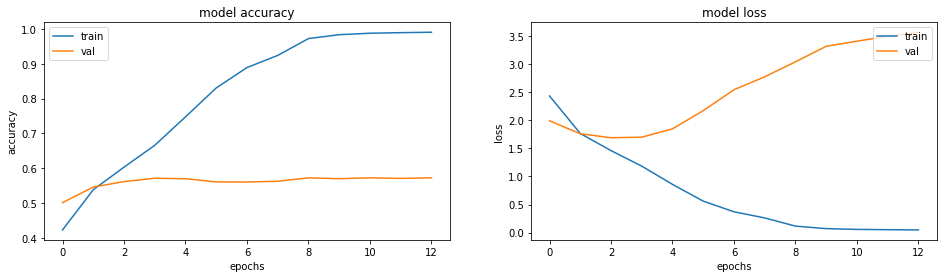

In [110]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [111]:
cnn_bilstm_model = tf.keras.models.load_model('cnn_bilstm_model.h5')

In [112]:
pred = cnn_bilstm_model.predict(X_test_reshaped)

print(classification_report(np.argmax(pred, axis=1), np.argmax(y_test_ohe, axis=1), target_names=labels))

                                                                                  precision    recall  f1-score   support

                                                                     Інші Подяки       0.19      0.34      0.24        56
                                              Інші технічні недоліки стану ліфту       0.42      0.53      0.47       228
                Аварійний, травмонебезпечний стан утримання об’єктів благоустрою       0.08      0.11      0.09        61
                                          Бажаючі отримати ”Картки киянина (КК)”       0.91      0.77      0.83        26
                              Будівництво /дооблаштування спортивних майданчиків       0.59      0.54      0.57        35
                                                                 Будівництво АЗС       0.59      0.61      0.60        28
                                                        Будівництво в нічний час       0.27      0.86      0.41         7
                       

## t-SNE visualization

In [113]:
from sklearn.manifold import TSNE

In [114]:
class_threshold = 1000
top_classes = target.loc[target.map(df['CallZType'].value_counts().to_dict()) > class_threshold].unique()
print(f"There are {top_classes.shape[0]} with number of accidents > {class_threshold}")

There are 25 with number of accidents > 1000


In [115]:
x_tsne, y_tsne = [], []

for vec_, label_ in zip(x_vec, target.values):
    if label_ in top_classes:
        x_tsne.append(vec_)
        y_tsne.append(label_)
len(x_tsne)

66737

In [116]:
tsne_model = TSNE(n_components=2, 
                  perplexity=40, 
                  n_iter=5000, 
                  random_state=RANDOM_SEED, 
                  metric='cosine',
                  learning_rate=200)

In [117]:
%%time

threshold = 5000

X_2d = tsne_model.fit_transform(x_tsne[:])
y = np.array(y_tsne[:])

CPU times: user 1h 2min 11s, sys: 1min 47s, total: 1h 3min 58s
Wall time: 20min 40s


In [118]:
matplot_colors = list(mcolors.BASE_COLORS.keys()) + \
                 list(mcolors.TABLEAU_COLORS.keys()) + \
                 list(mcolors.CSS4_COLORS.keys())
random_colors = np.random.choice(matplot_colors, len(top_classes), replace=False)
random_colors

array(['deepskyblue', 'indigo', 'aquamarine', 'lawngreen', 'm',
       'slateblue', 'k', 'antiquewhite', 'firebrick', 'blanchedalmond',
       'indianred', 'olivedrab', 'seagreen', 'wheat', 'darkslategrey',
       'mediumspringgreen', 'cadetblue', 'darksalmon', 'royalblue',
       'lime', 'darkviolet', 'bisque', 'darkblue', 'mediumslateblue',
       'lightslategray'], dtype='<U20')

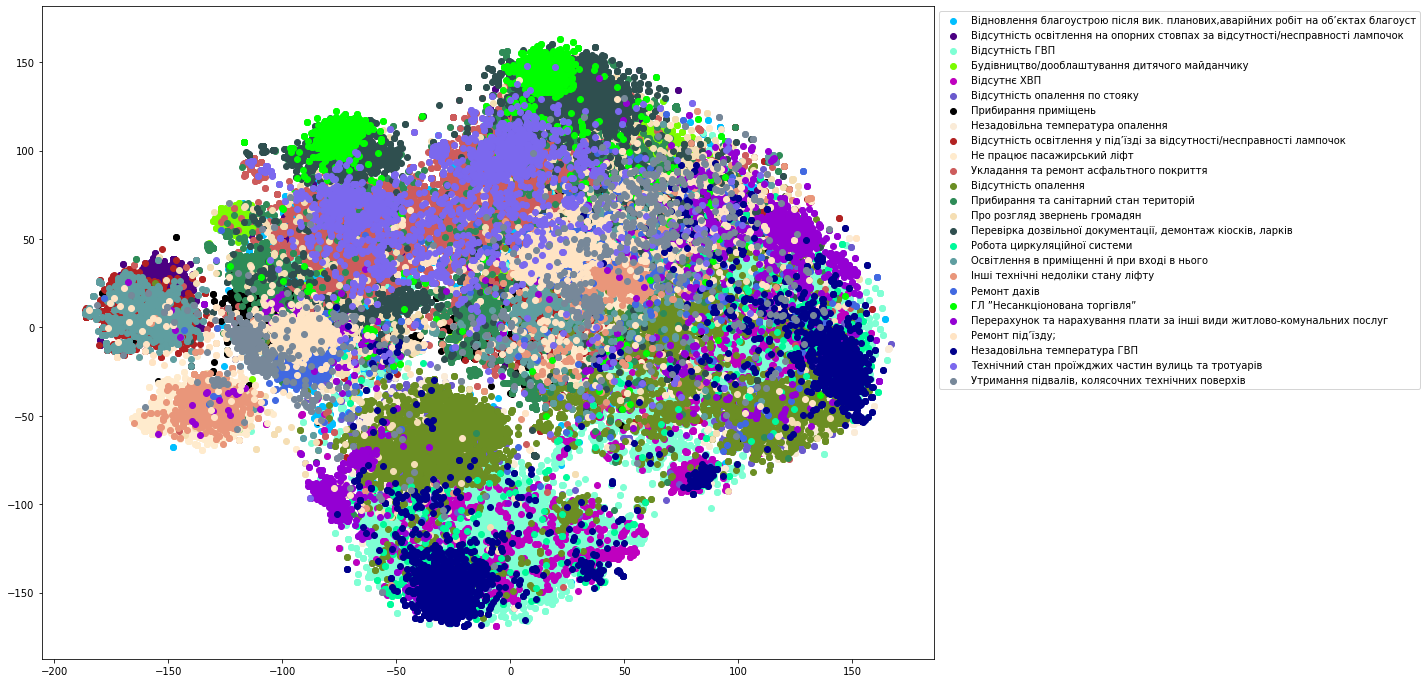

In [119]:
plt.figure(figsize=(16, 12))

for color, label in zip(random_colors, top_classes):
    plt.scatter(X_2d[y == label, 0], X_2d[y == label, 1], label=label, c=color)
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.))
plt.show()